# What is the Best Portfolio Optimization Method for You?
### Let's look at four portfolio optimization methods to find the right fit for your investing style.

#### By Justin Jimenez

One of my all-time favorite books about investing and trading is Jack Shwager's "Market Wizards". If you haven't read it yet (there's a free pdf on google and an audio version on YouTube), it's a series of interviews with some of the world's best traders and investors from the 80's. The interviews provide exceptional insight into the methods and attitudes of these skilled market participants, and the subjects of discussion cover a wide breadth of topics across different markets and trading styles.

Even though each interviewee was unique, there were a few key principles that were mentioned by many of them. One of those principles is risk management.

"[Bruce] Kovner lists risk management as the key to successful trading; he always decides on an exit point before he puts on a trade. He also stresses the need for evaluating risk on a portfolio basis rather than viewing the risk of each trade independently. This is absolutely critical when one holds positions that are highly correlated, since the overall portfolio risk is likely to be much greater than the trader realizes." 
― Jack D. Schwager, Market Wizards: Interviews With Top Traders

As an individual investor and trader, I too believe it is critical to maintain risk in individual positions and across the entire portfolio. However, with myriad ways to manage risk at both of these levels, it can be difficult to discern what is the best approach for your unique style and risk tolerance requirements. 

So, today I want to examine four portfolio optimization methods to show how they work and to evaluate why you might choose one strategy over another.

# Setup

In addition to explaining the details of each portfolio management method, I also want to show you how to implement each method in python. This way you will walk away from the story with the knowledge and the skill to put each method into action.
Therefore, before we explore each method, we have to cover a few basics.

## Generate a Portfolio and Analyze the Returns

The first step is to import relevant libraries and create a hypothetical portfolio to analyze. 
You can manually select the stocks you want to analyze and place them in a list (as below), but this exposes your portfolio to selection bias; you may not have selected the best performing stocks, which means that your portfolio performance is limited to the performance of your selection.


In [382]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import btalib
from empyrial import empyrial, Engine
import plotly.express as px

three_tickers = ["GOOG", "HPQ", "CMCSA"]

An alternative to manual selection would be to identify a key performance indicator (KPI) and then filter through a universe of stocks to select the ones that are top performers in regards to that KPI. This could be as simple as sorting out the highest small cap stocks (three-hundred million to two billion in market capitalization) with the highest EPS rank, or it could involve some technical indicator.

Here's an example of automatic selection of a universe. Let's say we only want to trade oversold tech stocks from the S&P 500. I found this example of how to create a DataFrame with all 500 companies from a Wikipedia table. If you don't trust Wikipedia, you can try this other solution I found, or collect the data from a brokerage API like Alpaca.

In [383]:
# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table

print(df.head())

  Symbol             Security SEC filings             GICS Sector  \
0    MMM                   3M     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV               AbbVie     reports             Health Care   
3   ABMD              Abiomed     reports             Health Care   
4    ACN            Accenture     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates    Saint Paul, Minnesota       1976-08-09   
1           Health Care Equipment  North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois       2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts       2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland       2011-07-06   

       CIK      Founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   81

The payload returns two tables, where the first table is the list of 500 companies and the second table is a list of changes to the S&P500 over the last several decades.

This DataFrame has columns for GICS Sector and GICS Sub-Industry, so you could further refine your universe with those two parameters you wanted to. In this case we're honing in on the information-technology sector.

In [384]:
IT_df = df[df['GICS Sector'] == 'Information Technology']
IT_symbols = IT_df['Symbol'].values.tolist()

print(IT_symbols)

['ACN', 'ADBE', 'AMD', 'AKAM', 'APH', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET', 'ADSK', 'ADP', 'AVGO', 'BR', 'CDNS', 'CDW', 'CDAY', 'CSCO', 'CTXS', 'CTSH', 'GLW', 'DXC', 'ENPH', 'FFIV', 'FIS', 'FISV', 'FLT', 'FTNT', 'IT', 'GPN', 'HPE', 'HPQ', 'INTC', 'IBM', 'INTU', 'IPGP', 'JKHY', 'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MA', 'MCHP', 'MU', 'MSFT', 'MPWR', 'MSI', 'NTAP', 'NLOK', 'NVDA', 'NXPI', 'ORCL', 'PAYX', 'PAYC', 'PYPL', 'PTC', 'QRVO', 'QCOM', 'CRM', 'STX', 'NOW', 'SWKS', 'SNPS', 'TEL', 'TER', 'TXN', 'TRMB', 'TYL', 'VRSN', 'V', 'WDC', 'WU', 'XLNX', 'ZBRA']


Now that we have a list of symbols for industrial companies in the S&P 500, we can filter this list with an indicator, such as the money flow index.

The money flow index essentially acts as a volume-weighted RSI to identify overbought and oversold signals. You can read more about the money flow index indicator here.

Although it is not recommended to use the MFI indicator by itself, that's what I'll do here for demonstration purposes. Keep in mind it would be ideal to combine this indicator with another indicator or pattern analysis to filter out false signals.

The function below accepts a list of symbols - tickers- as well as interval and period arguments for collecting historical price data (see the yfinance documentation for a list of available intervals and periods). It returns a list of historical data objects from yfinance as well as DataFrames for close history, returns of each symbol, the average expected return of each symbol, and a historical record of indicator values for the money flow index.

In [385]:
def hist_performance(tickers, interval, period, auto_adjust = True):
    historical_data_object = []
    close_hist = pd.DataFrame()
    indicator_hist = pd.DataFrame()
    returns = pd.DataFrame()
    expected_returns_avg = pd.DataFrame()

    
    [historical_data_object.append(yf.Ticker(f"{ticker}")) for ticker in tickers]
    
    for obj in historical_data_object:
        symbol = obj.info['symbol']
        hist = obj.history(period = period, auto_adjust = auto_adjust, interval = interval).dropna()
        close_hist[symbol] = hist.Close
        indicator_hist[symbol] = btalib.mfi(hist.High, hist.Low, hist.Close, hist.Volume).df.mfi

        obj_return = hist.Close.pct_change().dropna()
        returns[symbol] = obj_return
        
    expected_returns_avg[0] = returns.mean(axis=0)
    indicator_hist = indicator_hist.dropna()
    
    return historical_data_object, close_hist, returns, expected_returns_avg, indicator_hist

historical_data_object, close_hist, returns, expected_returns_avg, indicator_hist = hist_performance(IT_symbols, "1d", "5y")
print(indicator_hist)

                  ACN       ADBE        AMD       AKAM        APH        ADI  \
Date                                                                           
2018-05-16  39.671278  70.334809  81.817178  59.896364  64.508689  58.821374   
2018-05-17  40.910423  70.624735  74.491938  68.594860  63.028111  68.857961   
2018-05-18  47.668651  76.506675  82.158183  61.704415  65.173776  80.768594   
2018-05-21  53.990020  76.575355  82.543147  73.965349  72.253609  80.600887   
2018-05-22  53.594467  84.099828  76.177911  73.796675  64.224454  80.512211   
...               ...        ...        ...        ...        ...        ...   
2021-09-01  77.367519  55.358371  54.943576  38.906961  70.257053  41.580710   
2021-09-02  78.092785  49.100367  46.580302  39.913159  70.818292  42.936167   
2021-09-03  77.954419  56.106477  53.900384  46.331658  70.631472  43.004737   
2021-09-30  38.217992  22.753608  48.025486  31.241955  39.541157  40.092960   
2021-10-01  43.374021  22.568100  47.805

After calling this function, we can parse out the symbols that are in the overbought (MFI > 70) and oversold (MFI < 30) regions. Just for the sake of example, we will be adding the current oversold symbols to our portfolio. In a real application, you would wait for the MFI of these oversold companies to cross above 30 since there is no way of knowing how long they will be oversold for. Also, keep in mind that some analysts prefer to use other overbought and oversold levels, such as 80/20 and 90/10.

Text(2021-08-18 00:00:00, 80, 'These IT companies became \noversold, so we decide to construct a portfolio that anticipates a \nreturn on these stocks.')

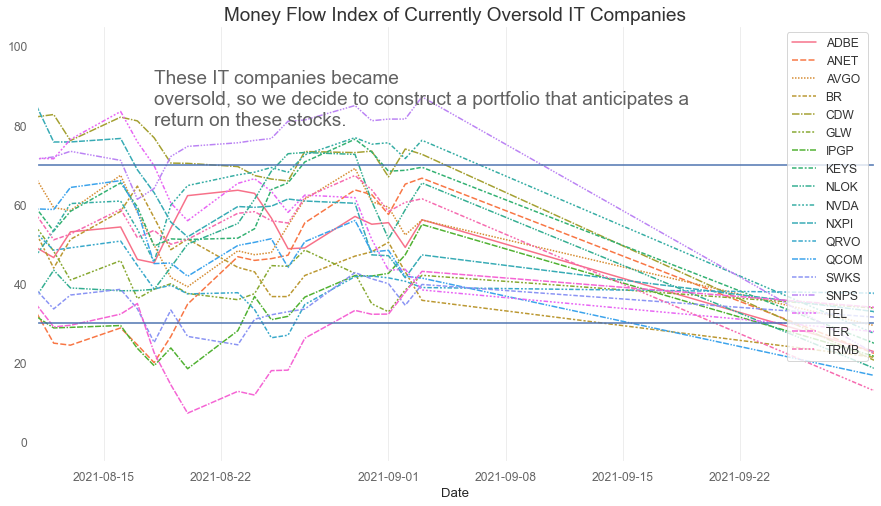

In [386]:
overbought_symbols = [column_name for column_name in indicator_hist.columns if indicator_hist[str(column_name)][-1] >= 70]
oversold_symbols = [column_name for column_name in indicator_hist.columns if indicator_hist[str(column_name)][-1] <= 30]

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(111)
plt.title('Money Flow Index of Currently Oversold IT Companies',fontsize=19,ha='center')
sns.lineplot(data=indicator_hist[oversold_symbols])
plt.axhline(30, 0,1)
plt.axhline(70, 0,1)
plt.grid(axis='y')
plt.xlim(indicator_hist.index[-20],18900)
plt.annotate("These IT companies became \noversold, so we decide to construct a portfolio that anticipates a \nreturn on these stocks.", xy=(indicator_hist.index[-15],80),color='#616161',fontsize=19)

Now that we have a selection of stocks that we anticipate will go up, we can look at different ways to optimize the portfolio.

# Baseline Portfolio

First I want to share two quick, basic portfolio allocation methods: 

1. equal weighted portfolios
2. market-weighted portfolios

I think it's important to have a baseline portfolio to compare the other methods against, so I'll quickly show you how to find the performance returns using these two simple approaches.

## Equal Weighted Portfolio

The weight of a holding in your portfolio refers to the percentage of your total equity that is allocated to that specific holding. An equal weighted portfolio uses the same fraction of your total equity for every holding, regardless of that asset's historical performance. This means that top-performers and laggards are treated equally.

Our hypothetical portfolio would have the following holdings:

In [387]:
print(f"The oversold companies are {oversold_symbols}.")

The oversold companies are ['ADBE', 'ANET', 'AVGO', 'BR', 'CDW', 'GLW', 'IPGP', 'KEYS', 'NLOK', 'NVDA', 'NXPI', 'QRVO', 'QCOM', 'SWKS', 'SNPS', 'TEL', 'TER', 'TRMB'].


Each holding would be allocated an equal fraction of the portfolio equity. To calculate the expected return of the portfolio, we multiply each holding's weight with the asset's expected average return (calculated by the hist_performance function). So, our expected returns in this equal weighted portfolio is:

In [388]:
numstocks = len(oversold_symbols)
equal_weights = np.repeat(1/numstocks, numstocks)
equal_weight_return_daily = []
avg_return = expected_returns_avg.loc[oversold_symbols, :][0]
annualized = ((1+avg_return)**252)-1
annualized_weighted = equal_weights * annualized
cumulative_annualized_weighted = np.sum(annualized_weighted)

print(f"The equal weighted portfolio's annualized average return is expected to be {round(cumulative_annualized_weighted*100,3)}%.")

The equal weighted portfolio's annualized average return is expected to be 36.544%.


Remember that the average of each asset's daily return was calculated based on the past five years of data. You should probably adjust the sample range to suit your holding periods.

## Market Cap Weighted Portfolio

Another simple alternative to the equal weighed portfolio is a market cap weighted portfolio, which allocates capital depending on the market capitalization of each company relative to the others in the portfolio.

The market capitalization can be accessed as follows:

In [389]:
mcaps = [obj.info['marketCap'] for obj in historical_data_object if obj.info['symbol'] in oversold_symbols] 
print(mcaps)

[274760204288, 26887634944, 200601059328, 19286212608, 25534199808, 31582103552, 8619436032, 30469701632, 14857414656, 516890624000, 51141890048, 18811893760, 145184882688, 27062042624, 46152413184, 46802788352, 18201139200, 21116194816]


Using this, we can calculate the market cap weight for each holding:

In [390]:
market_cap_weights = np.array([mcap / np.sum(mcaps) for mcap in mcaps])
print(market_cap_weights)

[0.18029336 0.01764325 0.13163129 0.01265531 0.01675514 0.02072368
 0.00565594 0.01999374 0.0097492  0.33917557 0.03355851 0.01234407
 0.09526806 0.01775769 0.03028449 0.03071126 0.0119433  0.01385612]


Then it's just a matter of multiplying the market cap weights with the annualized average returns.

In [391]:
mcap_portfolio_annual_return = annualized.mul(market_cap_weights).sum()
print(f"The expected annual return of the market cap weighted portfolio is {round(mcap_portfolio_annual_return,3)*100}%.")

The expected annual return of the market cap weighted portfolio is 53.0%.


So already we can see that the market cap weighted portfolio may provide slightly better results. However, let's look at the Sharpe ratio to learn why a higher expected return is not necessarily better.

# The Sharpe Ratio

When deciding between different portfolio distributions, in addition to considering the expected return, it's also important to consider how risky each portfolio distribution is relative to it's return. For this reason, it's common to compare the Sharpe ratio between potential portfolios.

The Sharpe ratio, created by William F. Sharpe in 1966, is the difference between the asset's return and the risk-free rate of return (the hypothetical return of an investment with zero risk) all divided by the asset's volatility (check out my story on statistical moments to calculate the volatility of your assets). For the sake of simplicity we will assume a risk free rate of zero.

To calculate the Sharpe ratio of our equal weighted and market cap weighted portfolios, we need the volatility of each asset, the covariance matrix, and the weights of holdings in the portfolio. We stored the daily returns from the past year of each company in returns from the hist_performance() function. We pass the returns into np.std() and use the .cov() method to obtain the standard deviation and covariance matrix respectively.

In [392]:
std_dev_daily = []
for ticker in returns[oversold_symbols]:
    std_dev_daily.append(np.std(returns[ticker].dropna()))
std_dev_annual = np.array(std_dev_daily) * (len(returns[oversold_symbols])**0.5)
print(std_dev_annual)

cov_daily = returns[oversold_symbols].cov()
cov_annualized = cov_daily * len(returns[oversold_symbols])
print(cov_annualized)

[0.71519091 0.94102514 0.77925283 0.54122171 0.68866041 0.71173654
 0.98240377 0.69743619 0.78574648 1.07396976 0.87537908 0.91562927
 0.82772246 0.86512599 0.63656271 0.63511382 0.89155854 0.76128451]
          ADBE      ANET      AVGO        BR       CDW       GLW      IPGP  \
ADBE  0.511905  0.314523  0.310932  0.201322  0.261727  0.253707  0.290319   
ANET  0.314523  0.886233  0.302192  0.210217  0.274224  0.310843  0.401236   
AVGO  0.310932  0.302192  0.607718  0.175562  0.274445  0.314765  0.351873   
BR    0.201322  0.210217  0.175562  0.293154  0.188387  0.205755  0.195212   
CDW   0.261727  0.274224  0.274445  0.188387  0.474630  0.293101  0.256292   
GLW   0.253707  0.310843  0.314765  0.205755  0.293101  0.506972  0.340569   
IPGP  0.290319  0.401236  0.351873  0.195212  0.256292  0.340569  0.965885   
KEYS  0.278219  0.284031  0.288727  0.176966  0.234815  0.266112  0.322806   
NLOK  0.189861  0.195572  0.164077  0.095741  0.150283  0.129666  0.187456   
NVDA  0.460817  0.

With this data we can calculate the portfolio volatility (σ) as the square root of the dot product of the transposed weights array with the dot product of the covariance matrix and the weights array.

$\sigma_{portfolio} = \surd {\omega_t \bullet \sum \bullet  \omega}$

In [393]:
equal_portfolio_std = np.sqrt(np.dot(equal_weights.T, np.dot(cov_annualized, equal_weights)))
print(f"The equal weighted portfolio annual volatility is {round(equal_portfolio_std,3)*100}%.")

mcap_portfolio_std = np.sqrt(np.dot(market_cap_weights.T, np.dot(cov_annualized, market_cap_weights)))
print(f"The market cap weighted portfolio annual volatility is {round(mcap_portfolio_std,3)*100}%.")

The equal weighted portfolio annual volatility is 57.49999999999999%.
The market cap weighted portfolio annual volatility is 69.5%.


Lastly, we can calculate the two Sharpe ratios as follows.

$S = \frac{R_a - r_f}{\sigma_a}$

In [394]:
equal_portfolio_sharpe = (cumulative_annualized_weighted - 0) / equal_portfolio_std
print(f"The equal weighted portfolio Sharpe ratio is {equal_portfolio_sharpe}.")

mcap_portfolio_sharpe = (mcap_portfolio_annual_return - 0) / mcap_portfolio_std
print(f"The market cap weighted portfolio Sharpe ratio is {mcap_portfolio_sharpe}.")

sharpe_ratios = []
sharpe_ratios.append(float(equal_portfolio_sharpe))
sharpe_ratios.append(float(mcap_portfolio_sharpe))

The equal weighted portfolio Sharpe ratio is 0.635635452382998.
The market cap weighted portfolio Sharpe ratio is 0.7631786401935791.


The Sharpe ratio's indicate that the equal weighted approach provides a slightly better return for the given risk taken, however both Sharpe ratios are relatively low. It would be ideal to see a Sharpe ratio above 1.

Let's see if we can improve our Sharpe ratio with some more sophisticated portfolio management methods.

# Using Empyrial for Portfolio Allocation

I recently mentioned this python package named Empyrial in last week's story "Five Resources I studied to Learn Quantitative Finance This Week". The package provides a simple solution for determining portfolio allocations and rebalancing position weights.

Empyrial currently offers a few different ways to allocate capital; I will showcase the global efficient frontier, mean-variance, minimum variance, and hierarchical risk parity methods.

## Global Efficient Frontier AKA MSR

The global efficient frontier, mean-variance, and minimum variance methods all stem from the modern portfolio theory established by Harry Markowitz with the Markowitz Mean-Variance Optimization model (I mentioned an interview with Markowitz in my last story). Each of these three methods simply select a portfolio weight distribution that lies on a different part of the efficient frontier depending on the risk tolerance of the portfolio manager.

I won't go too in depth about this model since I recently published a story exploring all the details. Essentially the Markowitz Mean-Variance approach is to generate a list of possible portfolios with random weight distributions and then find the optimal weight distribution at every level of volatility that provides the greatest expected return. These portfolios with optimal weight distribution are collectively referred to as the efficient frontier.

The "global efficient frontier" in Empyrial seems to be a misnomer given by the developers. I believe it actually refers to as the maximum Sharpe ratio method (MSR), since it returns the weight distribution that will provide the greatest Sharpe ratio - the portfolio with the greatest return and least volatility, found at the zenith of the efficient frontier.

Instead of defining a function to generate a series of random portfolios like I did in my other story, I can use the Engine class from Empyrial to do all of the work. I just have to specify how far back I want to back-test (I believe the package uses yahoo finance data), my portfolio, the optimization method, and other parameters such as rebalancing intervals and risk management.

In the example below I am back-testing the companies that are currently oversold using the "global efficient frontier" (optimizer = "EF").

In [395]:
portfolio_EF = Engine(
    start_date = "2016-10-01",
    portfolio = ['ADBE', 'ANSS', 'ANET', 'BR', 'CDW', 'GLW', 'IPGP', 'KEYS', 'NLOK', 'NVDA', 'NXPI', 'TRMB', 'ZBRA'],
    optimizer = "EF",
    rebalance = "1y",
)

portfolio_EF.weights

[0.0, 0.0, 0.0, 0.0, 0.43117, 0.0, 0.0, 0.0, 0.0, 0.56883, 0.0, 0.0, 0.0]

We can check the performance of the portfolio by passing the engine object into a new empyrial object as an argument.

Start date: 2016-10-01
End date: 2021-10-01


,Backtest
,
Annual return,68.95%
Cumulative return,1209.54%
Annual volatility,33.19 %
Winning day ratio,58.17%
Sharpe ratio,1.75
Calmar ratio,2.17
Information ratio,0.01
Stability,0.94
Max Drawdown,-31.03 %


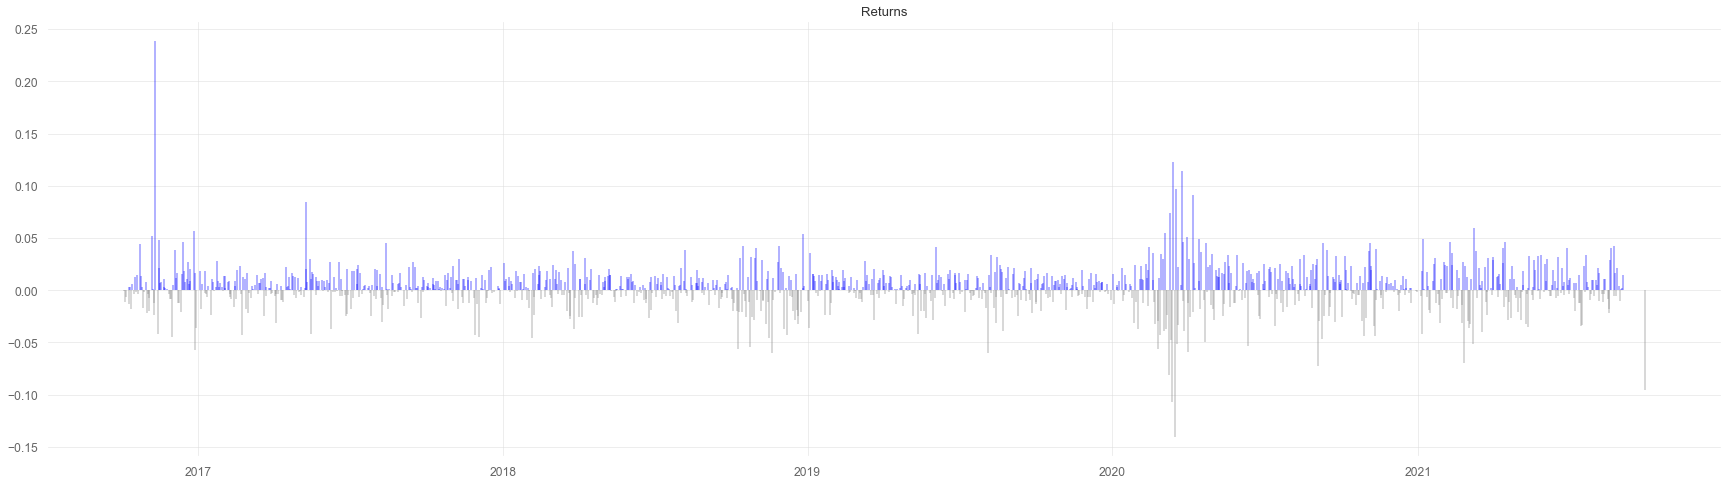

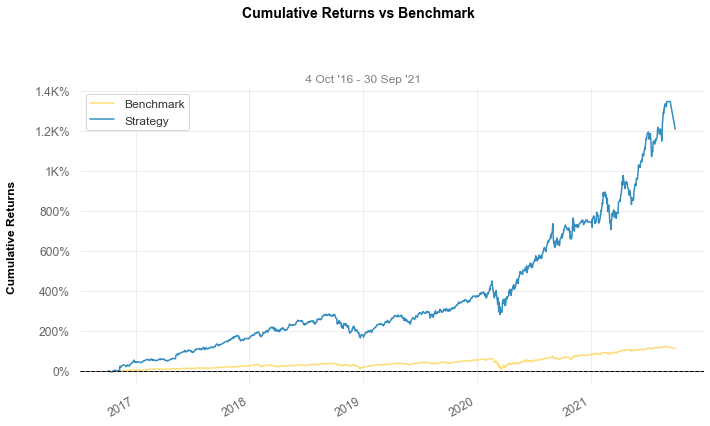

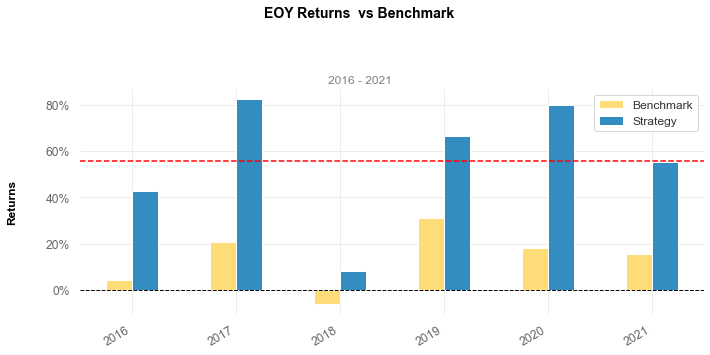

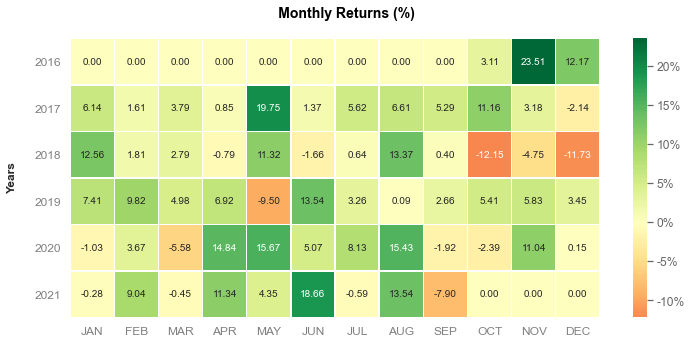

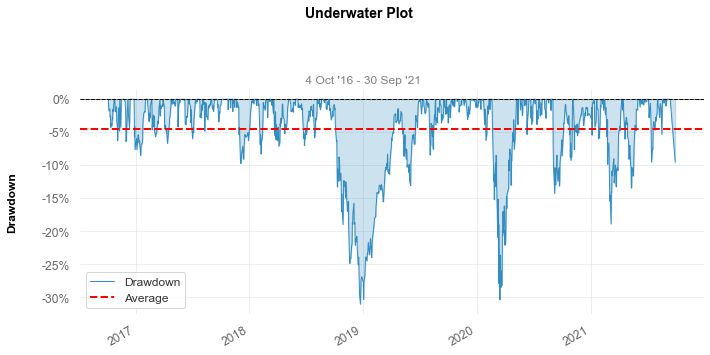

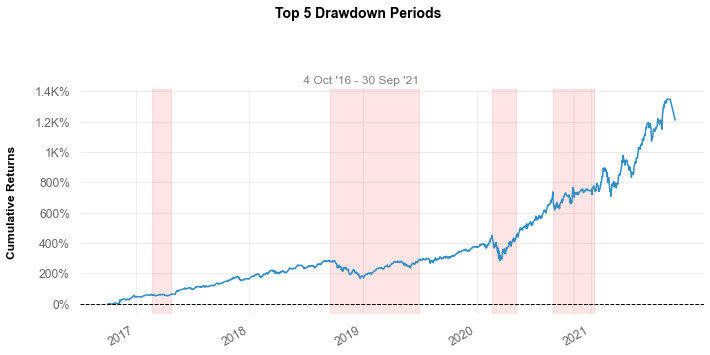

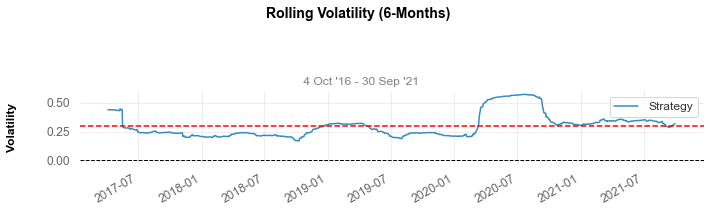

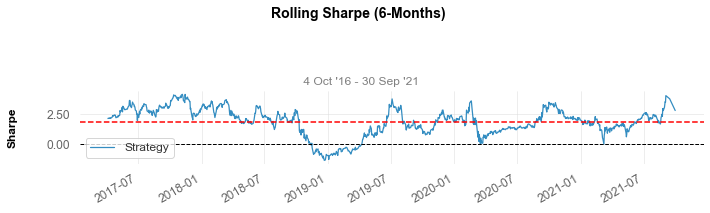

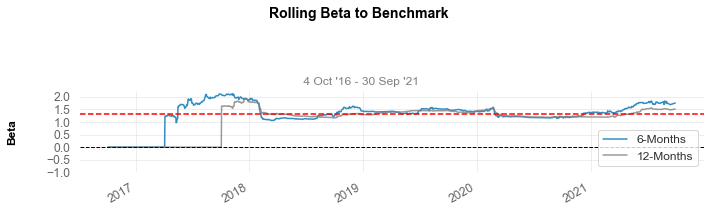

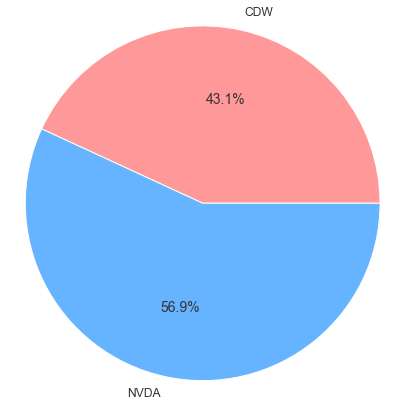

In [396]:
empyrial(portfolio_EF)
sharpe_ratios.append(empyrial.SR)

This report gives a lot of useful insights. It tells us that the rolling 6-month average Sharpe ratio is 1.24, and that the max drawdown was -30% (yikes).

You can call the empyrial.__dict__ dunder method to list all of the attributes of the report if you'd like to access a specific value for visualization.

For example, we can show the rebalancing orderbook with empyrial.orderbook, or we can save the Sharpe ratio from empyrial.SR.

In [397]:
print(empyrial.__dict__)

{'SR': '1.75', 'CR': '2.17', 'df': {'': ['Annual return', 'Cumulative return', 'Annual volatility', 'Winning day ratio', 'Sharpe ratio', 'Calmar ratio', 'Information ratio', 'Stability', 'Max Drawdown', 'Sortino ratio', 'Skew', 'Kurtosis', 'Tail Ratio', 'Common sense ratio', 'Daily value at risk', 'Alpha', 'Beta'], 'Backtest': ['68.95%', '1209.54%', '33.19 %', '58.17%', '1.75', '2.17', 0.01, '0.94', '-31.03 %', '2.7', '0.89', '17.97', '1.01', '1.41', '-3.0 %', 0.43, 1.29]}, 'returns': 2016-10-04   -0.000649
2016-10-05    0.000279
2016-10-06   -0.011158
2016-10-07   -0.006538
2016-10-10    0.003312
                ...   
2021-09-01    0.001485
2021-09-02    0.002172
2021-09-03    0.014323
2021-09-14    0.000000
2021-09-30   -0.095324
Length: 1236, dtype: float64, 'creturns': 2016-10-04     0.999351
2016-10-05     0.999630
2016-10-06     0.988476
2016-10-07     0.982014
2016-10-10     0.985266
                ...    
2021-09-01    14.239947
2021-09-02    14.270872
2021-09-03    14.475272

In [398]:
empyrial.orderbook

,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-30,2021-10-01
ADBE,0.00000,0.00000,0.13908,0.10546,0.15016,0.00000
ANSS,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
ANET,0.00000,0.09683,0.02212,0.00000,0.00000,0.00000
BR,0.00000,0.24796,0.24543,0.15047,0.12396,0.00000
CDW,0.00000,0.00000,0.17457,0.39668,0.00000,0.24813
GLW,0.00000,0.09843,0.00000,0.00000,0.00000,0.00000
IPGP,0.00000,0.14262,0.00000,0.00000,0.00000,0.00000
KEYS,0.00000,0.00000,0.14662,0.14226,0.10152,0.00000
NLOK,0.19855,0.00000,0.00000,0.00000,0.00000,0.00000
NVDA,0.80145,0.41415,0.22442,0.16456,0.49585,0.75187


Consider using this method if you are not particularly risk averse and you are willing to accept greater potential risk for a higher potential return.


## Mean-Variance

Instead of selecting the maximum Sharpe ratio portfolio with the "global efficient frontier" optimizer, you might decide that you want to select the portfolio with optimal returns for a specific risk level. The mean-variance optimizer in Empyrial can be used to find the portfolio on the efficient frontier at a maximum risk level by setting the max_vol parameter.

This optimizer will not work if the max_vol value is too low or if the assets in the portfolio are too volatile for your chosen risk level.

Consider using this method if you have a particular risk appetite and want to optimize your portfolio in accordance with your unique risk tolerance.

In [399]:
portfolio_MEANVAR = Engine(
    start_date = "2016-10-01",
    portfolio = ['ADBE', 'ANSS', 'ANET', 'BR', 'CDW', 'GLW', 'IPGP', 'KEYS', 'NLOK', 'NVDA', 'NXPI', 'TRMB', 'ZBRA'],
    optimizer = "HRP",
    rebalance = "1y",
    max_vol = 20
)

portfolio_MEANVAR.weights

[0.0,
 0.0,
 0.20391,
 0.0,
 0.22482,
 0.0,
 0.18603,
 0.0,
 0.0003,
 0.0937,
 0.1272,
 0.16394,
 0.0]

Start date: 2016-10-01
End date: 2021-10-01


,Backtest
,
Annual return,30.99%
Cumulative return,275.92%
Annual volatility,24.36 %
Winning day ratio,56.55%
Sharpe ratio,1.23
Calmar ratio,1.04
Information ratio,0.0
Stability,0.93
Max Drawdown,-29.07 %


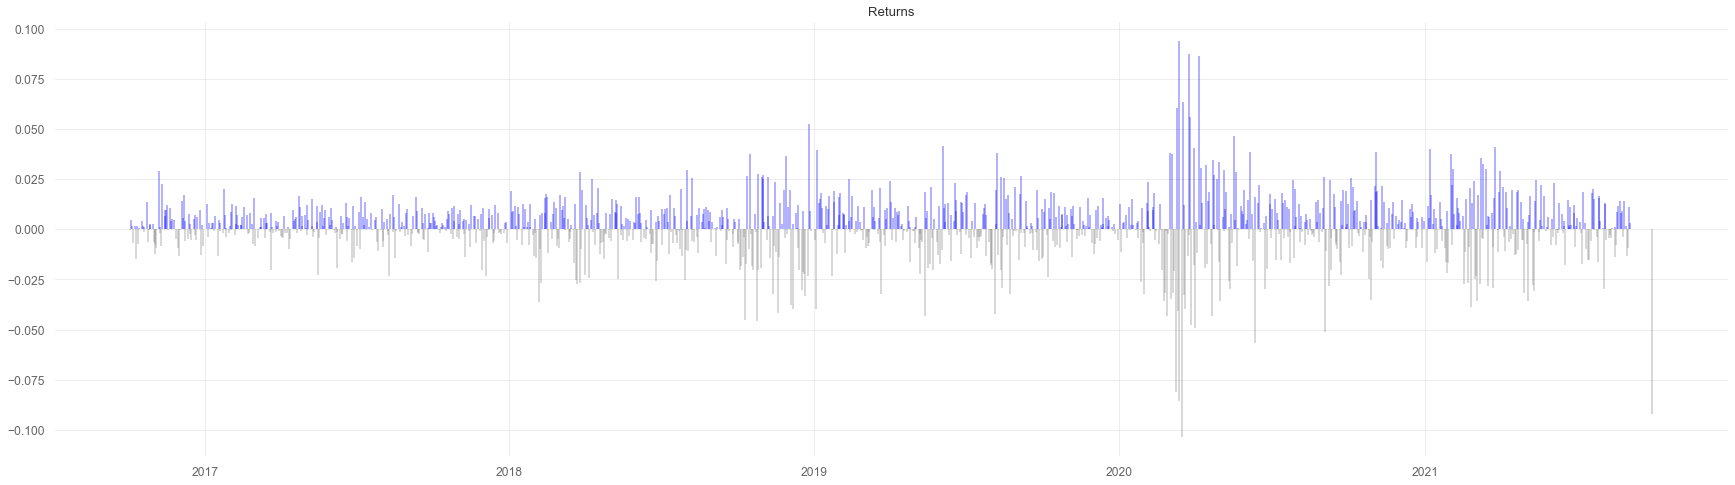

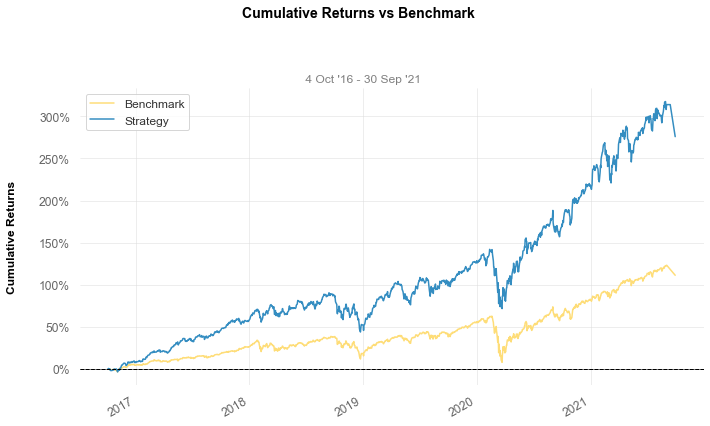

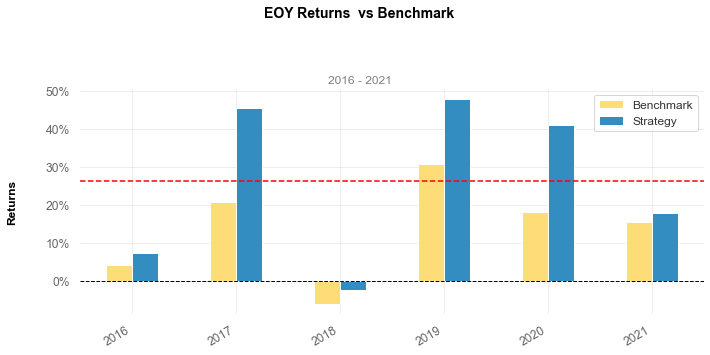

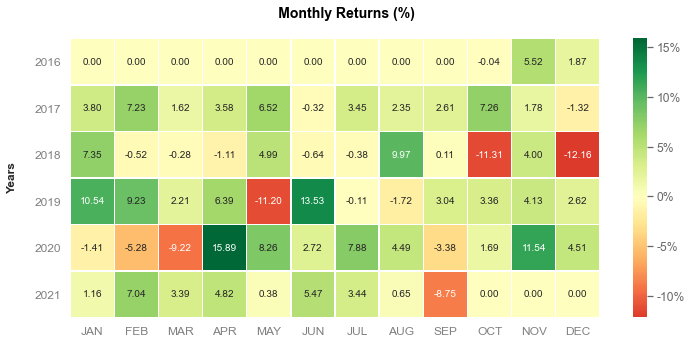

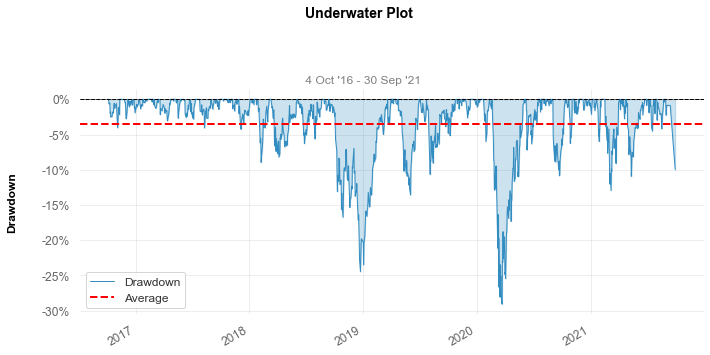

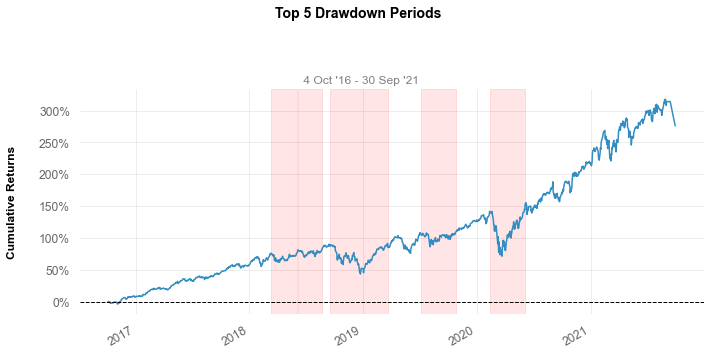

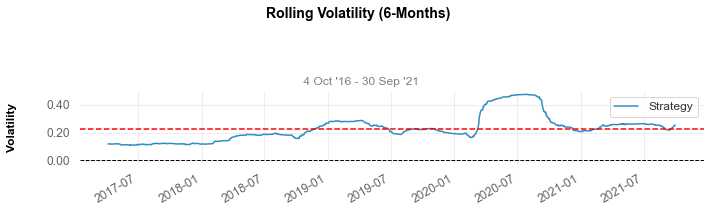

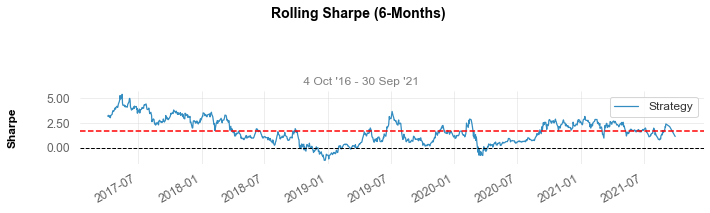

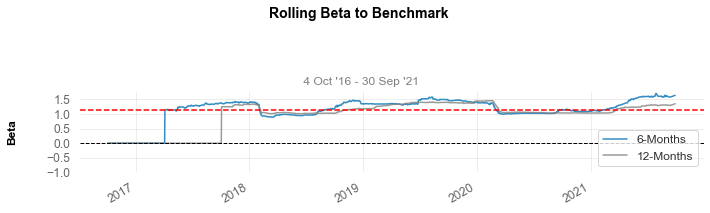

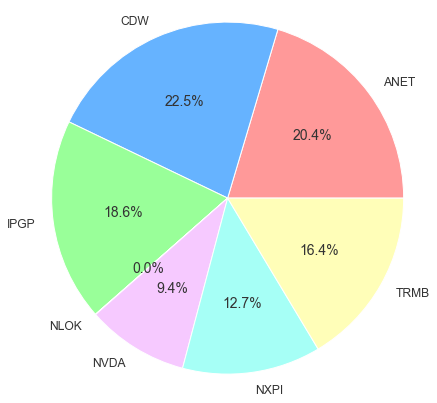

In [400]:
empyrial(portfolio_MEANVAR)
sharpe_ratios.append(empyrial.SR)


## Minimum Variance

As you might suspect, the minimum variance method returns the portfolio with the least volatility on the efficient frontier. This is sometimes referred to as the global minimum volatility portfolio (GMV).

According to the DataCamp course I am working through:

"[The] GMV portfolio often outperforms the MSR portfolios out of sample even though the MSR would outperform quite significantly in-sample. Of course, out of sample results are what really matters in finance."

Consider using this method with an aggressive risk management approach if you are particularly risk averse.

In [401]:
portfolio_MINVAR = Engine(
    start_date = "2016-10-01",
    portfolio = ['ADBE', 'ANSS', 'ANET', 'BR', 'CDW', 'GLW', 'IPGP', 'KEYS', 'NLOK', 'NVDA', 'NXPI', 'TRMB', 'ZBRA'],
    optimizer = "MINVAR",
    rebalance = "1y",
)

portfolio_MINVAR.weights

[0.0765,
 0.07822,
 0.07,
 0.09811,
 0.08145,
 0.07864,
 0.06666,
 0.08148,
 0.09591,
 0.05323,
 0.0703,
 0.07803,
 0.07147]

Start date: 2016-10-01
End date: 2021-10-01


,Backtest
,
Annual return,32.4%
Cumulative return,296.15%
Annual volatility,24.61 %
Winning day ratio,57.44%
Sharpe ratio,1.26
Calmar ratio,1.08
Information ratio,0.0
Stability,0.92
Max Drawdown,-29.36 %


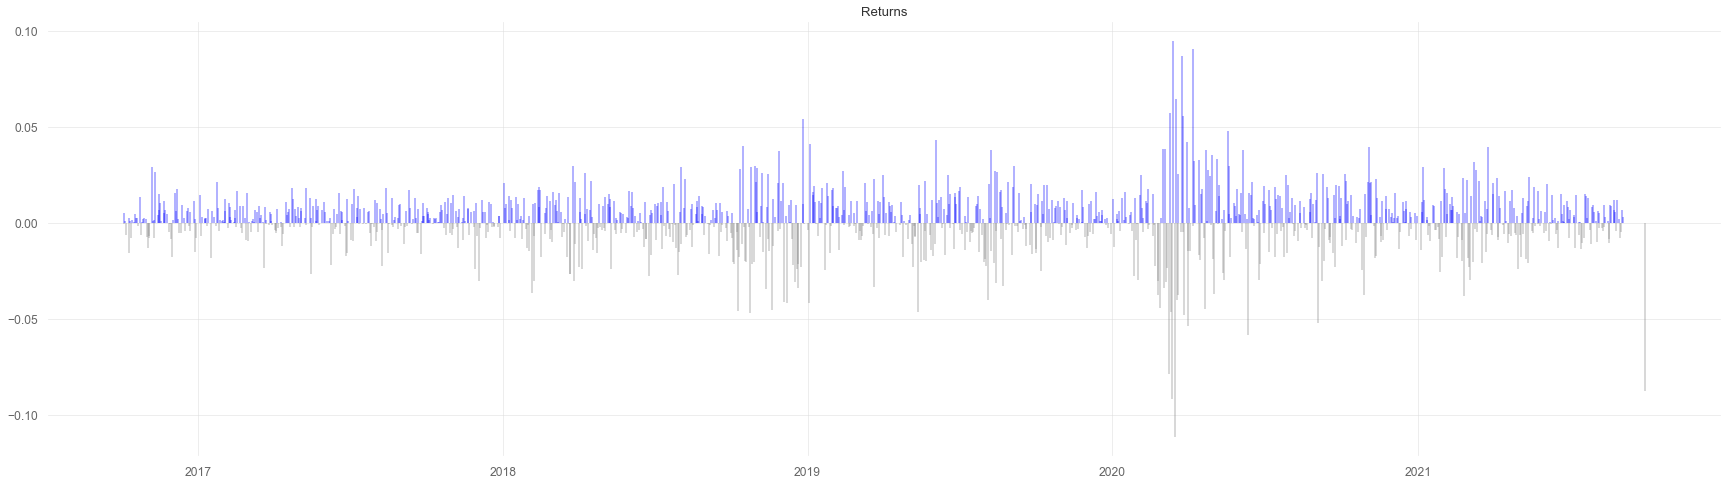

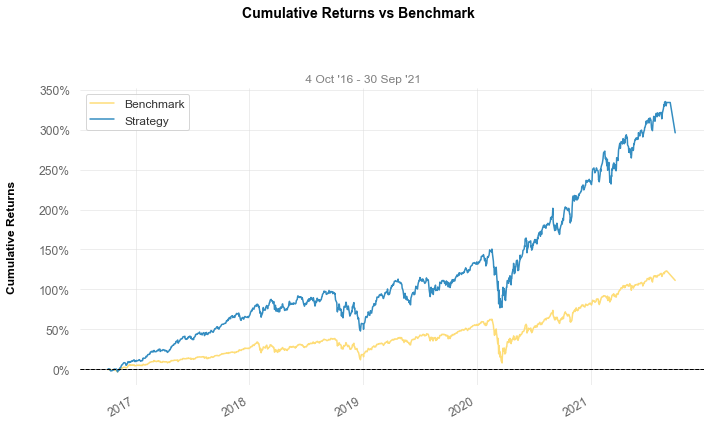

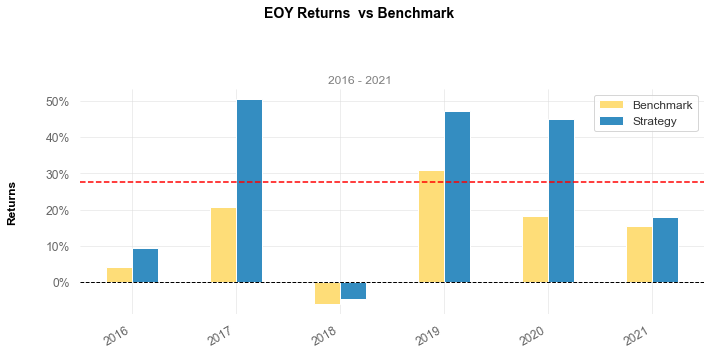

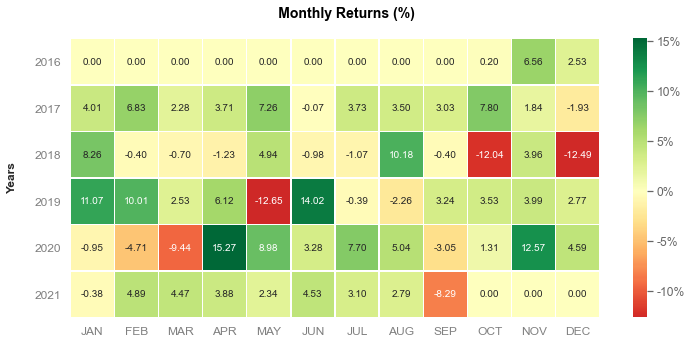

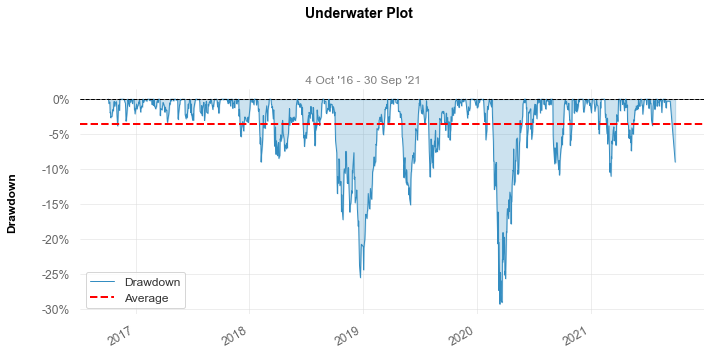

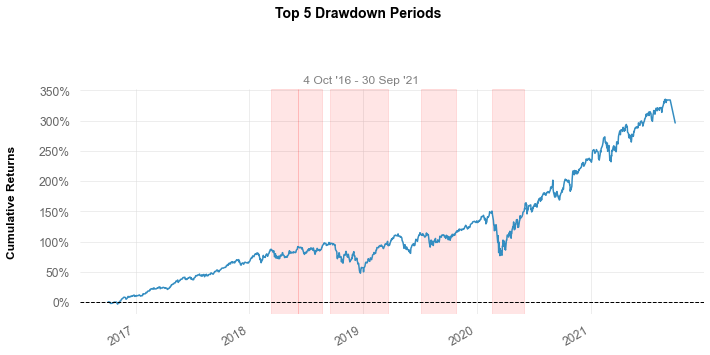

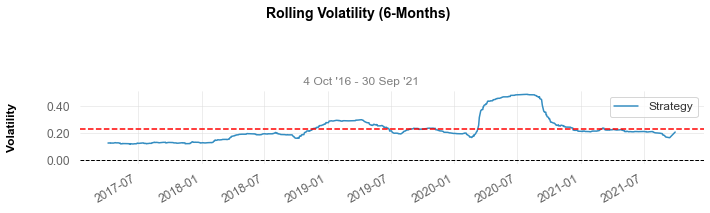

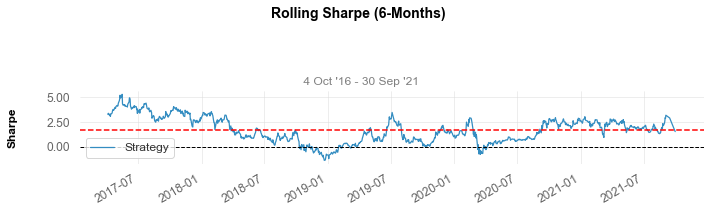

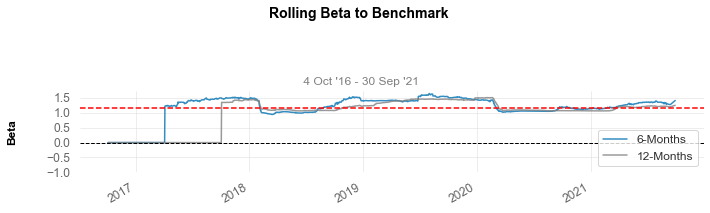

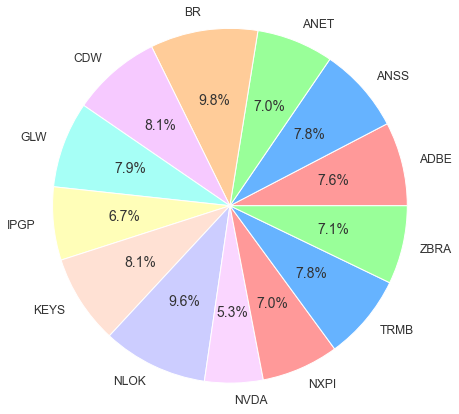

In [402]:
empyrial(portfolio_MINVAR)
sharpe_ratios.append(empyrial.SR)


## Hierarchical Risk Parity

According to this paper written by Johann Pfitzinger and Nico Katzke about hierarchical risk parity, "[the] algorithm applies machine learning techniques to identify the underlying hierarchical correlation structure of the portfolio, allowing clusters of similar assets to compete for capital. The resulting allocation is both well-diversified over risk sources and intuitively appealing."

I'll admit that I don't yet consider myself an expert on hierarchical risk parity since I haven't constructed the model from scratch myself. However, as I understand it, the model seeks to create a diversified portfolio purely based on risk rather than some relationship between risk and return such as with mean variance.

The HRP method can be broken down into three steps: 

1. Hierarchical tree clustering to group assets with similar levels of risk together. Clusters are visualized with a dendrogram.
2. "Quasi-diagonalization of the asset correlation matrix" - a superfluous name for matrix seriation.
3. Recursive bisection to hierarchically assign weights within clusters.

If you'd like to learn more about the math and research behind HRP, check out these post from Hudson and Thames, Quantpedia, and PortfolioOptimizer, or watch this quick overview of an HRP implementation in MATLAB:
[HRP in MATLAB](https://www.youtube.com/watch?v=e21MfMe5vtU)


In [403]:
portfolio_HRP = Engine(
    start_date = "2016-10-01",
    portfolio = ['ADBE', 'ANSS', 'ANET', 'BR', 'CDW', 'GLW', 'IPGP', 'KEYS', 'NLOK', 'NVDA', 'NXPI', 'TRMB', 'ZBRA'],
    optimizer = "HRP",
    rebalance = "1y",
)

portfolio_HRP.weights

[0.0,
 0.0,
 0.20391,
 0.0,
 0.22482,
 0.0,
 0.18603,
 0.0,
 0.0003,
 0.0937,
 0.1272,
 0.16394,
 0.0]

Start date: 2016-10-01
End date: 2021-10-01


,Backtest
,
Annual return,30.58%
Cumulative return,276.38%
Annual volatility,23.96 %
Winning day ratio,56.31%
Sharpe ratio,1.23
Calmar ratio,1.05
Information ratio,0.0
Stability,0.93
Max Drawdown,-29.07 %


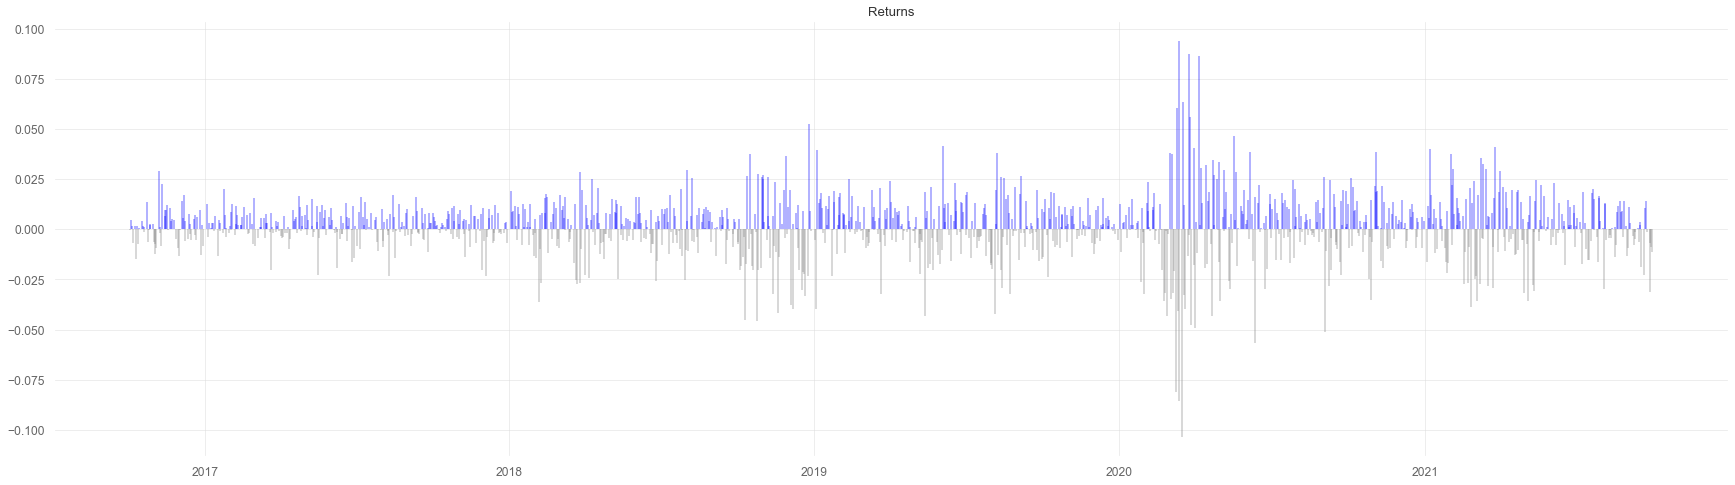

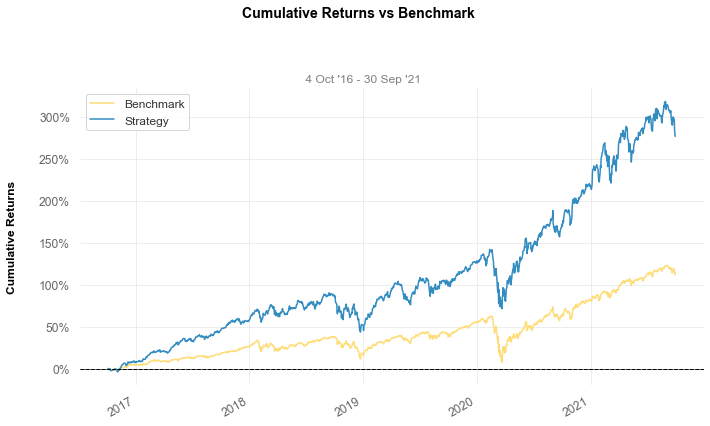

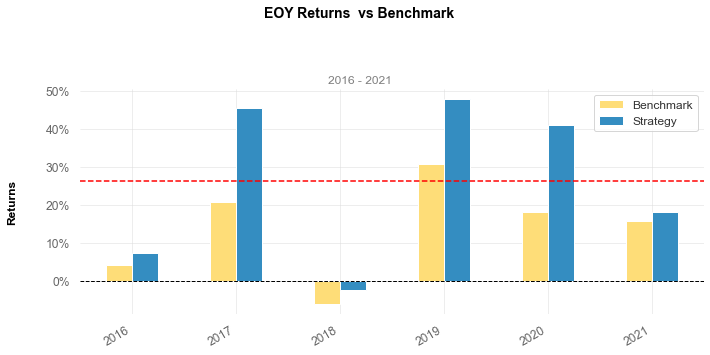

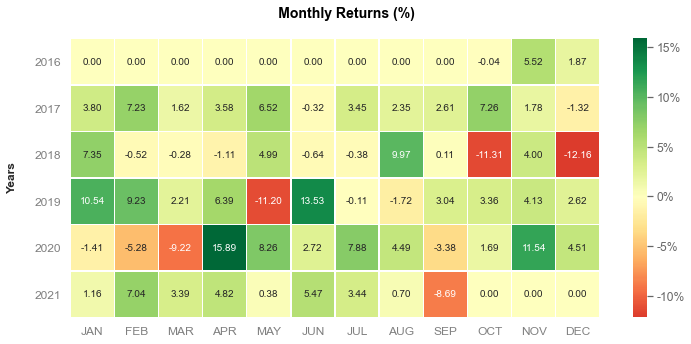

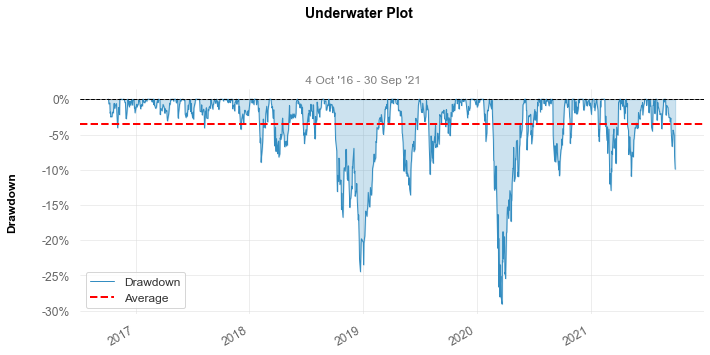

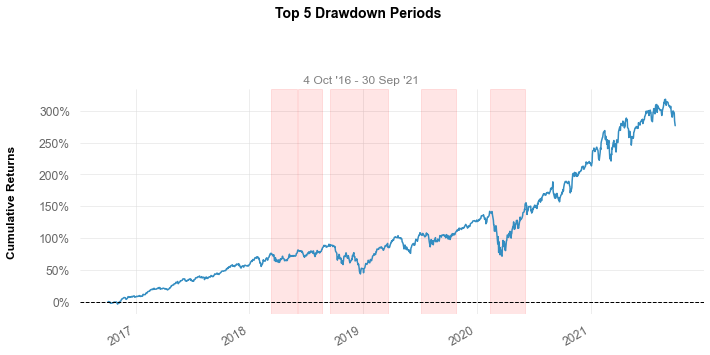

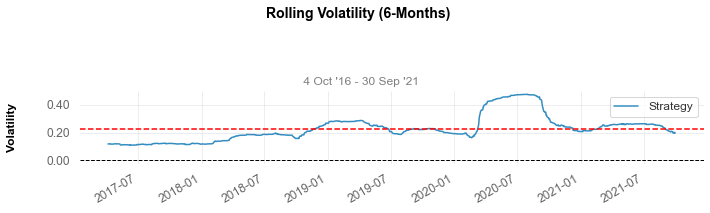

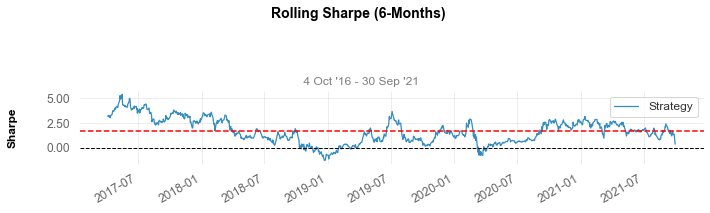

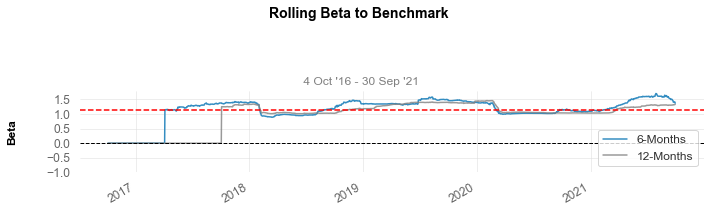

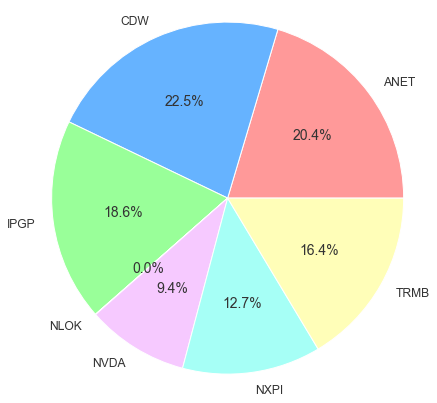

In [404]:
empyrial(portfolio_HRP)
sharpe_ratios.append(empyrial.SR)

Consider using this method if your primary concern is the diversification of your risk rather than the magnitude of the return.

# Comparison of Results

With a simple bar graph we can visualize the resultant Sharpe ratios of the four methods. It's clear that the "global efficient frontier" optimizer produces the Maximum Sharpe Ratio portfolio. However, this portfolio also suffered the greatest maximum drawdown at -31.09% (the other three empyrial optimizers suffered drawdowns around -29%). 

In [405]:
labels = ['EQUAL','MCAP','EF', 'MEANVAR', 'MINVAR', 'HRP']
x = list(range(len(sharpe_ratios)))
color_discrete_map = {'EF': 'rgb(0,0,0)'}
fig = px.bar(x=labels, y = [float(_) for _ in sharpe_ratios], 
             labels={'x':'Portfolio Optimization Method', 'y':'Sharpe Ratio'},
             color = sharpe_ratios,
            )
fig.update_layout(yaxis_range=[.5,1.9])
fig.show()

# Considerations

Based on the results, you might conclude that the MSR portfolio is the best optimization method across the board. However, before coming to any conclusion, consider the followings flaws with my demonstration.

The main flaw is that my demonstration shows the historical performance on a portfolio whose holdings were selected based on the recent oversold MFI values. In practice, you would close the postions that become overbought (or trigger some other exit signal) and you would rebalance the portfolio by purchasing stocks that are oversold at the time of rebalancing.

The second flaw is that none of these portfolios implement any form of active risk management. The Engine class does provide a parameter for managing risk by establishing a max drawdown, take profit, or stop loss level. You can choose to add this parameter to any of the portfolio back tests, but in practice you should implement a risk management strategy on each holding. 

The third flaw is that the rolling Sharpe ratio average only spans 6 months. To get a more accurate understanding of the historical performance of each optimization method, it might be useful to analyze the Sharpe ratio on a longer time frame. 

In addition, you might consider that the Sharpe ratio might not be the best indicator of performance. I recently came across this story about analyzing portfolio performance using different metrics, and the author explained:

"Simply because a price changes, doesn't mean that you're taking on more risk! By looking at the standard deviation, the Sharpe Ratio punishes moves up in price and moves down in price. I can't think of an investor who thinks that their strategy is risky because it made money." - Raposa Technologies

For this reason, you might find decide that it is more reasonable to evaluate portfolios using the Sortino ratio (returns measured against negative volatility) or the Calmar ratio (returns measured against maximum drawdown).

The fourth flaw that I noticed occurred when I was reviewing the graph of the MFI. You might have noticed that the values changed linearly from the beginning of September 2021 to the current date (beginning of October 2021). This is because the yfinance package did not return data for several companies within this time range, and the rows were dropped using the .dropna() method.

The last significant flaw that I noticed was that, for some strange reason, my list variable for oversold_symbols became shorter with each instantiation of the Engine class. I don't know why, but the assets that were allocated weights equal to zero would be dropped out of the oversold_symbols list at each instantiation. Therefore, I recommend explicitly listing the symbols in each instantiation as I have done in my examples above.

If you plan on using Empyrial to rebalance your portfolio weight distribution at regular intervals, I recommend using a flask app with the Flask-APScheduler package. You could create a function with a list of symbols as an argument and use the Engine class to update the weights within the function. This function could then be called at regular intervals using Flask-APScheduler. I plan on showing an example of this sort of functionality in a future story, so keep an eye out for that.

# In Summary

In each of the four Empyrial methods that were tested against the SPY, all four methods easily outperformed the benchmark and the baseline optimization methods. Therefore, it's easy to conclude that any of these four optimization methods would be better than no optimization method at all. Beyond that, selecting one optimization method over another comes down to personal risk tolerance and personal preference on how what metric to use to evaluate portfolio performance.

If you have a low risk tolerance, consider using the HRP or global minimum volatility (minimum variance) portfolio. If you want to manage your portfolio at a specific maximum level of volatility, consider using the mean-variance optimizer. And if you want to maximize performance with no concern for maximum drawdown, consider using the Maximum Sharpe Ratio portfolio (global efficient frontier optimizer).

I sincerely hope that this story helps inform you on different approaches to portfolio optimization. I wanted to give you the basic understanding and tools necessary to successfully implement a portfolio management method that's suitable for your unique risk tolerance.


# References
1. [Small Cap Stocks Definition](https://news.marketcap.com/small-cap-definition/#:~:text=Small%20Cap%20Definition%201%20Understanding%20Small%20Cap.%20The,the%202000%20smallest%20companies%20in%20the%20Russell%203000.)
2. [Picking Stocks With EPS Rank](https://www.investors.com/how-to-invest/investors-corner/eps-rating-is-key-to-picking-great-stocks/#:~:text=An%20EPS%20Rating%20of%2099%20indicates%20that%20a,the%20Research%20Tables%20and%20stock%20charts%20in%20IBD.)
3. [How To Get A List Of Companies in SP500 With Python](https://tcoil.info/how-to-get-list-of-companies-in-sp-500-with-python/)
4. [How To Get A List Of Tickers By Industry Name](https://stackoverflow.com/questions/65118810/how-to-get-a-list-of-stock-tickers-by-entering-a-sector-name)
5. [BTALib Indicators](https://btalib.backtrader.com/indgroups/#mfi)
6. [MFI Investopedia](https://www.investopedia.com/terms/m/mfi.asp)
7. [Market Wizards Quotes](https://www.goodreads.com/work/quotes/951666-market-wizards)
8. [MFI Explanation](https://school.stockcharts.com/doku.php?id=technical_indicators:money_flow_index_mfi)
9. [yfinance package](https://pypi.org/project/yfinance/)
10. [Risk Free Rate Of Return Investopedia](https://www.investopedia.com/terms/r/risk-freerate.asp)
11. [Risk Free Rate Of Return The Balance](https://www.thebalance.com/what-is-risk-free-rate-of-return-5097109#:~:text=Key%20Takeaways%201%20A%20risk-free%20rate%20of%20return,investors%20evaluate%20economic%20conditions%20and%20compare%20various%20assets.)
12. [Empyrial Python Package](https://empyrial.gitbook.io/empyrial/)
13. [A constrained hierarchical risk parity algorithm with cluster-based capital allocation](https://ideas.repec.org/p/sza/wpaper/wpapers328.html)
14. [What is Portfolio Variance?](https://corporatefinanceinstitute.com/resources/knowledge/finance/portfolio-variance/)
15. [The Hierarchical Risk Parity Algorithm: An Introduction](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)
16. [Hierarchical Risk Parity Quantpedia](https://quantpedia.com/hierarchical-risk-parity/)
17. [Hierarchical Risk Parity Portfolio Optimizer](https://portfoliooptimizer.io/blog/hierarchical-risk-parity-introducing-graph-theory-and-machine-learning-in-portfolio-optimizer/)
18. [HRP in MATLAB](https://www.youtube.com/watch?v=e21MfMe5vtU)
19. [5 Risk Metrics You Should Know Before Trading](https://medium.com/raposa-technologies/5-risk-metrics-you-should-know-before-trading-595a864e33d6)
20. [I Used Python to Develop Investment Portfolio Performance Indicators](https://python.plainenglish.io/i-used-python-to-develop-investment-portfolio-performance-indicators-c52a7671d49b)
21. [Selection Bias](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/EP/EP713_Bias/EP713_Bias2.html)

